### Part 1: Building the Core Architecture

This notebook covers the main part of the project: implementing the custom Swin Transformer model. The first step is to define all the custom layers needed, like PatchEmbedding, WindowAttention, and the main SwinTransformer block itself. This is the foundation of the model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import os

# --- Model Hyperparameters ---
num_classes = 5
input_shape = (224, 224, 3)
patch_size = (4, 4)
num_heads = 6
embed_dim = 96
num_mlp = 384
qkv_bias = True
window_size = 7
shift_size = 3
image_dimension = 224

# --- Calculate patch details ---
num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]
print(f"Number of patches: {num_patch_x}x{num_patch_y} = {num_patch_x * num_patch_y}")

Number of patches: 56x56 = 3136


### Helper Functions

These two functions are used to partition the image into windows and then reverse the proccess. This is a core idea of the Swin Transformer to compute attention locally.

In [2]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x, (-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows

def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows, (-1, patch_num_y, patch_num_x, window_size, window_size, channels)
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

### Core Layers Implementation

Now, I'm defining the main custom layers for the model.

1.  **WindowAttention**: Computes self-attention within local windows.
2.  **SwinTransformer**: The main block that combines window attention with the MLP.
3.  **PatchEmbedding**: Converts image patches to vector embeddings.
4.  **PatchMerging**: Downsamples the image by merging patches, which creates the hirearchical structure.

In [3]:
@keras.saving.register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        # Define relative position bias
        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(self.relative_position_bias_table, relative_position_index_flat, axis=0)
        relative_position_bias = ops.reshape(relative_position_bias, (num_window_elements, num_window_elements, -1))
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0), "float32")
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)

        attn = self.dropout(attn)
        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
@keras.saving.register_keras_serializable()
class SwinTransformer(layers.Layer):
    def __init__(self, dim, num_patch, num_heads, window_size=7, shift_size=0, num_mlp=1024, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_patch = num_patch
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)
        self.mlp = keras.Sequential([
            layers.Dense(num_mlp),
            layers.Activation(keras.activations.gelu),
            layers.Dropout(dropout_rate),
            layers.Dense(dim),
            layers.Dropout(dropout_rate),
        ])
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size > 0:
            height, width = self.num_patch
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(mask_windows, axis=2)
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(initializer=attn_mask, shape=attn_mask.shape, dtype=attn_mask.dtype, trainable=False)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(x_windows, (-1, self.window_size * self.window_size, channels))
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = ops.reshape(attn_windows, (-1, self.window_size, self.window_size, channels))
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)
        if self.shift_size > 0:
            x = ops.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x
@keras.saving.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)
@keras.saving.register_keras_serializable()
class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

### Model Assembly

Now I will assemble the layers together to build the final model. For this first attempt, I'll use a simple structure with two SwinTransformer blocks followed by a patch merging layer and a final classification head.

In [4]:
# --- Model Assembly ---
patch_feature_dim = patch_size[0] * patch_size[1] * input_shape[2]
num_patches_total = num_patch_x * num_patch_y
input_layer_shape = (num_patches_total, patch_feature_dim)

input_tensor = layers.Input(shape=input_layer_shape)

# Stage 1
x = PatchEmbedding(num_patches_total, embed_dim)(input_tensor)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    name="swin_stage1_block1"
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    name="swin_stage1_block2"
)(x)

# Downsampling
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)

# Final Classification Head
x = layers.LayerNormalization(epsilon=1e-5)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

# Create the final model
model = keras.Model(input_tensor, output)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3136, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embedding                 │ (None, 3136, 96)       │       305,760 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_stage1_block1              │ (None, 3136, 96)       │       115,255 │
│ (SwinTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_stage1_block2              │ (None, 3136, 96)       │       268,919 │
│ (SwinTransformer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging (PatchMerging)    │ (None, 784, 192)       │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 784, 192)       │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765,011 (3.52 MB)

 Trainable params: 606,545 (2.31 MB)

 Non-trainable params: 158,466 (1.21 MB)

### Part 2: Data Loading and Initial Training Attempt

With the model architecture defined, the next step is to load the pre-processed data and create the `tf.data` pipeline. This involves loading the NumPy arrays we saved earlier and setting up the data pipeline for training.

After that, I will compile the model and run the first training experiment to get a baseline performance.

In [5]:
# --- Training Hyperparameters ---
learning_rate = 1e-3
batch_size = 64
num_epochs = 150
weight_decay = 0.0001
label_smoothing = 0.1

# --- Load Pre-processed Data ---
# Note: This assumes Google Drive is mounted.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_LOAD_DIR = "/content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented"
    x_train = np.load(os.path.join(DRIVE_LOAD_DIR, 'X_train.npy'))
    y_train = np.load(os.path.join(DRIVE_LOAD_DIR, 'y_train_one_hot.npy'))
    # For now, I will create a validation set from the training data for a quick check
    print(f"Loaded x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
except Exception as e:
    print(f"Error loading data. Make sure you've run the preprocessing notebook. Details: {e}")

Mounted at /content/drive
Loaded x_train shape: (8790, 224, 224, 3) - y_train shape: (8790, 5)


### Create `tf.data` Pipeline

I'm creating the data pipeline. One important step here is extracting patches from the images, because the Swin Transformer doesn't work on whole images directly. The `patch_extract_wrapper` function handles this.

In [6]:
# This function extracts patches from images, a required step for the model
def patch_extract_wrapper(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

# Creating a validation split from the training data for this run
val_split_index = int(len(x_train) * 0.9)
x_val_split = x_train[val_split_index:]
y_val_split = y_train[val_split_index:]
x_train_split = x_train[:val_split_index]
y_train_split = y_train[:val_split_index]


# Create the training dataset pipeline
dataset = (
    tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# Create the validation dataset pipeline
dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Training and validation tf.data pipelines created.")

Training and validation tf.data pipelines created.


### Compile and Train the Model

Now, everything is ready. I'll compile the model with the AdamW optimizer and categorical cross-entropy loss. Then, I will start the first training run.

### Update: Resolving a Memory Error

After running the initial setup, the training failed due to a `ResourceExhaustedError`. Even with Google Colab Pro, the `batch_size` of 128 proved to be too demanding for the GPU. To fix this, I'm reducing the batch size to a more reasonable value of 64. I will now restart the training.

In [10]:
# Compile the model
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Start training
print("\nStarting the first training experiment...")
history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)


Starting the first training experiment...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 71s 394ms/step - accuracy: 0.4366 - loss: 1.6350 - top-2-accuracy: 0.6984 - val_accuracy: 0.6564 - val_loss: 1.1385 - val_top-2-accuracy: 0.8180
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.6291 - loss: 1.1702 - top-2-accuracy: 0.7836 - val_accuracy: 0.6655 - val_loss: 1.0978 - val_top-2-accuracy: 0.8191
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.6552 - loss: 1.1073 - top-2-accuracy: 0.8119 - val_accuracy: 0.6803 - val_loss: 1.0738 - val_top-2-accuracy: 0.8237
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.6696 - loss: 1.0780 - top-2-accuracy: 0.8221 - val_accuracy: 0.6860 - val_loss: 1.0707 - val_top-2-accuracy: 0.8225
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6724 - loss: 1.0722 - top-2-accuracy: 0.8246 - val_accuracy: 0.6758 - val_loss: 1.0601 - val_top-2-accuracy: 0.8259
Epoch 6/150
124/124 ━━━━━━━

### Part 3: Analyzing the First Training Results

The training has now completed, and the results are not ideal. As can be seen from the logs above, the training accuracy climbed to over 97%, but the validation accuracy stalled around 68% and then started to fluctuate or even decrease. Similarly, the validation loss began to increase after an initial drop.

This is a clear indication of **severe overfiting**. The model has memorized the training set but failed to generalize to new data. For the next attempt, I need to implement a mechanism to stop the training process before this overfitting becomes too extreme.

### Part 4: Visualizing Performance and Adding Evaluation Metrics

To get a clearer picture of the overfitting problem, I'll now visualize the training history. I'm also adding more detailed evaluation functions to generate classification reports and confusion matrices for future experiments.

In [13]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    # Function to plot the training and validation curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the curves from the completed training run
print("Plotting the training history from the first experiment...")
#plot_training_history(history)



def evaluate_model(model, dataset):
    print("\nGenerating predictions for evaluation...")
    y_pred_probs = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true_classes = []
    for _, labels in dataset:
        y_true_classes.extend(np.argmax(labels.numpy(), axis=1))

    y_true_classes = np.array(y_true_classes)

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    # Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Evaluation functions defined.")

Plotting the training history from the first experiment...
Evaluation functions defined.


### Part 5: Second Training Attempt with Callbacks

Based on the analysis of the first run, the key issue was training for too long. To combat this, I will now introduce Keras Callbacks into the training process.

1.  **`EarlyStopping`**: This will monitor the `val_loss` and stop the training automatically when it stops improving, preventing the model from overfitting.
2.  **`ModelCheckpoint`**: This will save only the best version of the model (the one with the lowest `val_loss`) during the entire training process.

This is a much more robust approach to training.

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    patience=10,              # Stop training if val_loss doesn't improve for 10 consecutive epochs
    verbose=1,                # Print messages when stopping
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Define the path to save the best model
best_model_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras"

model_checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True, # Only save the model if `val_loss` has improved
    verbose=1
)

print("Callbacks for Early Stopping and Model Checkpointing have been defined.")

Callbacks for Early Stopping and Model Checkpointing have been defined.


### Re-compiling and Re-training

I will re-compile the model to reset its weights and then start the training process again, this time using the callbacks. I'm still setting `epochs` to a high number, but I expect the `EarlyStopping` callback to finish the training much earlier.

In [9]:
# Re-compile the model to reset the optimizer and weights
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Start the second, improved training run
print("\nStarting the second training experiment with callbacks...")
history_improved = model.fit(
    dataset,
    epochs=150, # Set a high number, but expect it to stop early
    validation_data=dataset_val,
    callbacks=[early_stopping_callback, model_checkpoint_callback] # Pass the callbacks here
)

print("\n--- Improved Training Finished ---")


Starting the second training experiment with callbacks...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4229 - loss: 1.8175 - top-2-accuracy: 0.6239
Epoch 1: val_loss improved from inf to 1.16785, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 71s 406ms/step - accuracy: 0.4233 - loss: 1.8146 - top-2-accuracy: 0.6245 - val_accuracy: 0.6268 - val_loss: 1.1679 - val_top-2-accuracy: 0.8100
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6004 - loss: 1.1992 - top-2-accuracy: 0.7792
Epoch 2: val_loss improved from 1.16785 to 1.08371, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step - accuracy: 0.6005 - loss: 1.1990 - top-2-accuracy: 0.7792 - val_accuracy: 0.6667 - val_loss: 1.0837 - val_top-2-accuracy: 0.8225
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6493 - loss: 1.1141 - top-2-

### Analyzing the Improved Training Run

Now let's plot the history from this second run. I expect to see that the training stopped before the validation loss started to increase significantly.

Plotting the training history from the second, improved experiment...


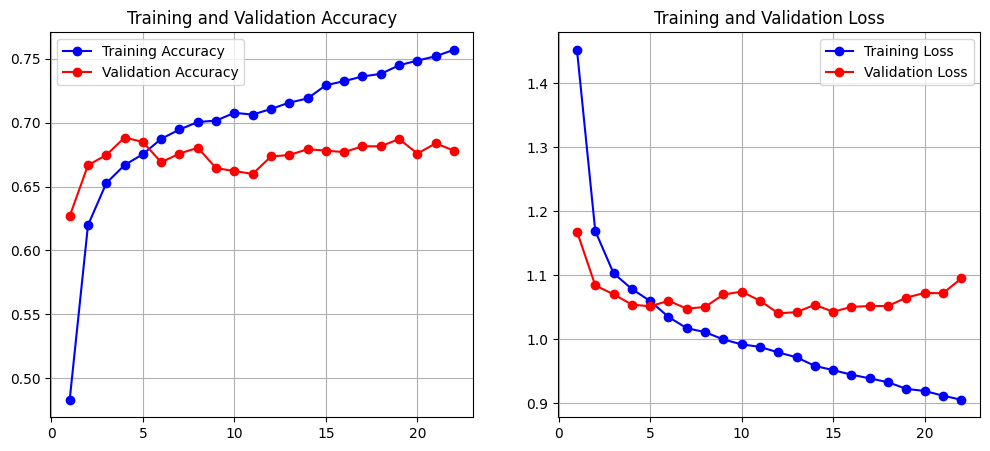


Loading the best model saved at: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras

--- Final Evaluation on Validation Set (using best model) ---

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step

--- Classification Report ---
               precision    recall  f1-score   support

        No DR       0.84      0.92      0.87       465
         Mild       0.21      0.37      0.27        63
     Moderate       0.54      0.59      0.57       240
       Severe       1.00      0.02      0.05        42
Proliferative       0.00      0.00      0.00        69

     accuracy                           0.67       879
    macro avg       0.52      0.38      0.35       879
 weighted avg       0.65      0.67      0.64       879


--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


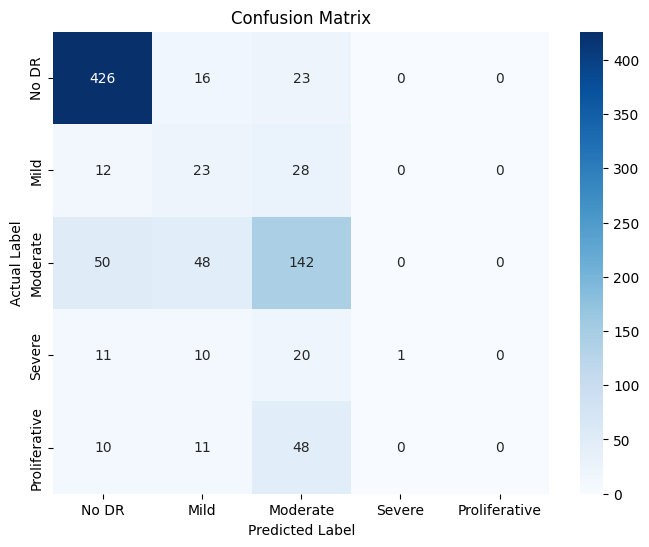

In [14]:
# Plot the results of the second training run
print("Plotting the training history from the second, improved experiment...")
plot_training_history(history_improved)

# Load the best model that was saved by ModelCheckpoint
print(f"\nLoading the best model saved at: {best_model_path}")
best_model = keras.models.load_model(best_model_path)

# Finally, evaluate the *best* model on the validation set
print("\n--- Final Evaluation on Validation Set (using best model) ---")
evaluate_model(best_model, dataset_val)

### Part 6: Final Analysis of the Improved Model

The second training run, which used `EarlyStopping`, has now completed. The process stopped automatically, preventing the severe overfitting seen in the first attempt.

Now, I will load the best version of the model that was saved by `ModelCheckpoint`. However, loading a model with custom layers requires a special step. I encountered a `TypeError` because Keras doesn't natively know about my `PatchEmbedding` or `SwinTransformer` layers.

To solve this, I will pass a `custom_objects` dictionary to the `load_model` function. This dictionary explicitly tells Keras which class to use for each custom layer name, ensuring the model can be correctly reconstructed. After loading, I will perform a final, detailed evaluation on the validation set.

Plotting the training history from the second experiment...


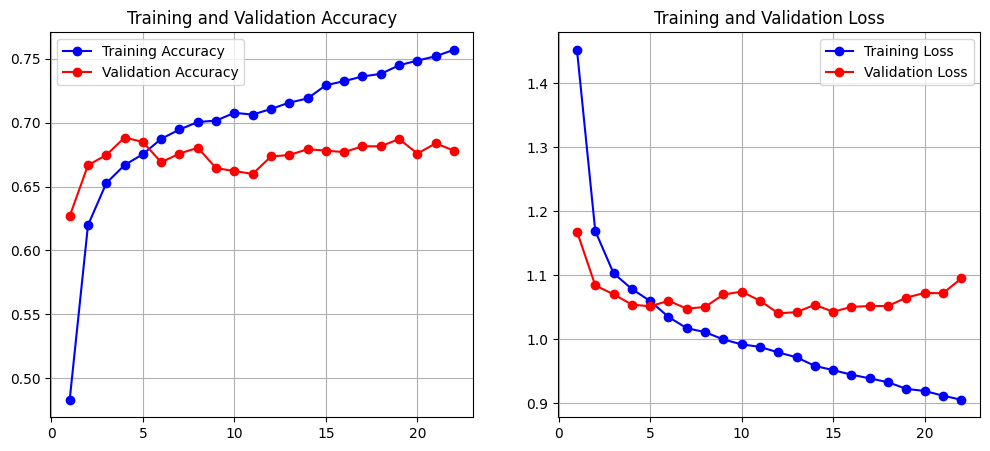


Loading the best model from: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_merging', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Best model loaded successfully!

Preparing validation data for final evaluation...

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step

--- Classification Report (Validation Set) ---
               precision    recall  f1-score   support

        No DR       0.84      0.92      0.87       465
         Mild       0.21      0.37      0.27        63
     Moderate       0.54      0.59      0.57       240
       Severe       1.00      0.02      0.05        42
Proliferative       0.00      0.00      0.00        69

     accuracy                           0.67       879
    macro avg       0.52      0.38      0.35       879
 weighted avg       0.65      0.67      0.64       879


--- Confusion Matrix (Validation Set) ---


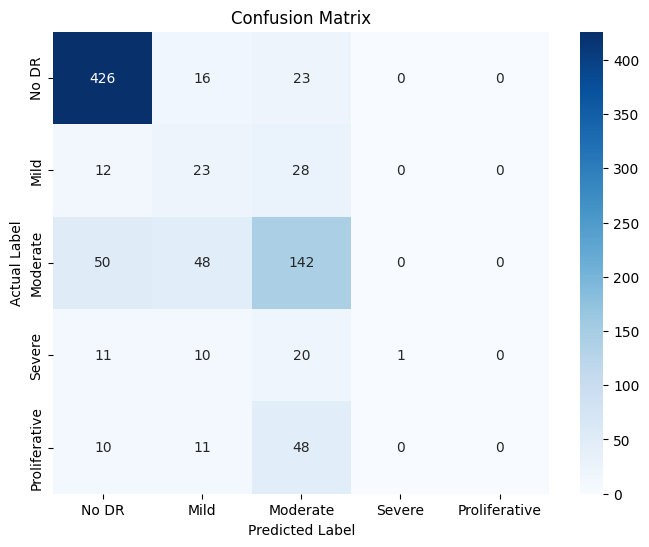

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Helper Functions for Evaluation ---

def plot_training_history(history):
    # This function plots the training and validation curves.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, dataset):
    # This function generates a classification report and confusion matrix.
    print("\nGenerating predictions for evaluation...")
    y_pred_probs = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true_classes = []
    for _, labels in dataset:
        y_true_classes.extend(np.argmax(labels.numpy(), axis=1))

    y_true_classes = np.array(y_true_classes)

    # Ensure lengths match, which can be an issue with batching
    min_len = min(len(y_true_classes), len(y_pred_classes))
    y_true_classes = y_true_classes[:min_len]
    y_pred_classes = y_pred_classes[:min_len]

    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    # Classification Report
    print("\n--- Classification Report (Validation Set) ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))

    # Confusion Matrix
    print("\n--- Confusion Matrix (Validation Set) ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- Main Execution for Analysis ---

# 1. Plot the history from the successful training run
print("Plotting the training history from the second experiment...")
plot_training_history(history_improved)

# 2. Define custom objects and load the best model
custom_objects = {
    "WindowAttention": WindowAttention,
    "SwinTransformer": SwinTransformer,
    "PatchEmbedding": PatchEmbedding,
    "PatchMerging": PatchMerging,
}
best_model_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights.keras"
print(f"\nLoading the best model from: {best_model_path}")
best_model = keras.models.load_model(best_model_path, custom_objects=custom_objects)
print("Best model loaded successfully!")


# 3. Create a fresh dataset for evaluation and evaluate the model
print("\nPreparing validation data for final evaluation...")
dataset_val_eval = (
    tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
    .batch(batch_size)
    .map(lambda x, y: (patch_extract_wrapper(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

evaluate_model(best_model, dataset_val_eval)

### Part 7: Third Training Attempt - Addressing Class Imbalance for Higher Accuracy

The previous experiment successfully solved the overfitting problem, but the final validation accuracy (around 68%) is still lower than desired. The classification report revealed that the model struggles significantly with the minority classes (Mild, Severe, Proliferative).

This is a classic class imbalance problem. In this final experiment, I will attempt to improve the model's performance on these classes with two main strategies:

1.  **Class Weights**: By providing `class_weight` to the `.fit()` method, I will force the model's loss function to apply a higher penalty for misclassifying the rare classes. This should encourage it to learn their features more effectively.
2.  **Lower Learning Rate**: I am also reducing the learning rate from `1e-3` to `1e-4`. A smaller learning rate allows for more careful and stable adjustments to the model's weights, which can be crucial for learning the subtle differences in the minority classes without "overshooting" the optimal solution.

My goal with this experiment is to push the validation accuracy closer to the 80% mark.

In [16]:
from sklearn.utils import class_weight
import numpy as np

# We need the original integer labels from the training split to calculate class weights
y_train_integers = np.argmax(y_train_split, axis=1)

# Calculate class weights using sklearn's utility
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Keras requires the weights in a dictionary format
class_weights_dict = dict(enumerate(class_weights))

print("Calculated Class Weights to counteract imbalance:")
print(class_weights_dict)

Calculated Class Weights to counteract imbalance:
{0: np.float64(0.41235340109460517), 1: np.float64(1.8903225806451613), 2: np.float64(0.7244505494505494), 3: np.float64(3.7671428571428573), 4: np.float64(2.499526066350711)}



Starting the third training experiment with class weights and tuned learning rate...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6843 - loss: 1.3336 - top-2-accuracy: 0.8344
Epoch 1: val_loss improved from inf to 1.19836, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 391ms/step - accuracy: 0.6843 - loss: 1.3334 - top-2-accuracy: 0.8342 - val_accuracy: 0.5882 - val_loss: 1.1984 - val_top-2-accuracy: 0.7088
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6634 - loss: 1.2858 - top-2-accuracy: 0.7863
Epoch 2: val_loss improved from 1.19836 to 1.18372, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - accuracy: 0.6635 - loss: 1.2857 - top-2-accuracy: 0.7864 - val_accuracy: 0.5939 - val_loss: 1.1837 - val_top-2-accuracy: 0.7133
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - a

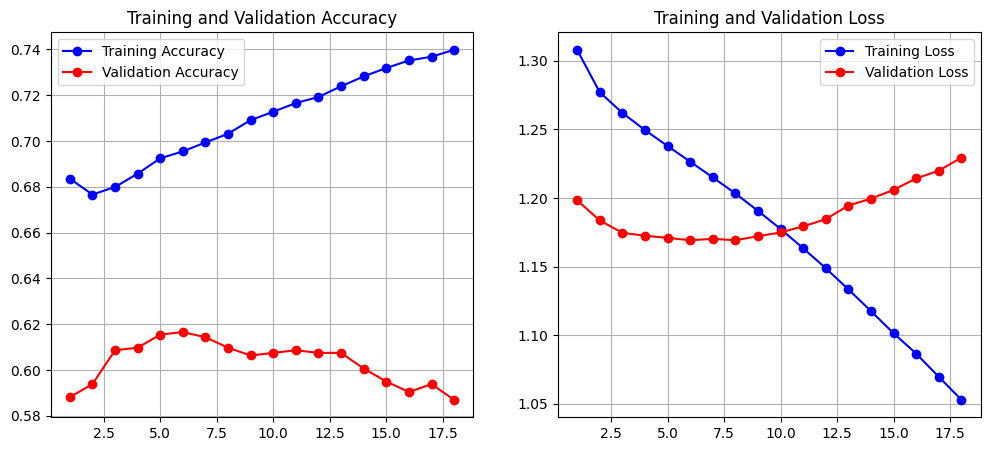


Loading the best tuned model from: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_merging', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



--- Final Evaluation on Validation Set (using best tuned model) ---

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step

--- Classification Report (Validation Set) ---
               precision    recall  f1-score   support

        No DR       0.88      0.86      0.87       465
         Mild       0.19      0.52      0.27        63
     Moderate       0.64      0.36      0.46       240
       Severe       0.13      0.21      0.16        42
Proliferative       0.13      0.07      0.09        69

     accuracy                           0.61       879
    macro avg       0.39      0.41      0.37       879
 weighted avg       0.67      0.61      0.62       879


--- Confusion Matrix (Validation Set) ---


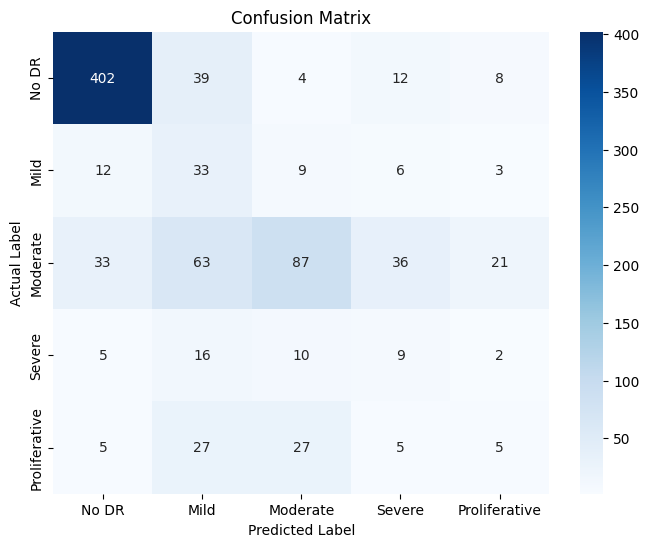

In [17]:
# --- Re-training with Class Weights and a Lower Learning Rate ---

# First, re-define the learning rate
learning_rate_tuned = 1e-4

# Re-compile the model to reset its state and apply the new learning rate
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate_tuned, # Using the new, lower learning rate
        weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Define a new path for the improved model
best_model_tuned_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras"

# We can reuse the early stopping callback, but we need a new ModelCheckpoint
model_checkpoint_tuned_callback = ModelCheckpoint(
    filepath=best_model_tuned_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

print("\nStarting the third training experiment with class weights and tuned learning rate...")
history_tuned = model.fit(
    dataset,
    epochs=150,
    validation_data=dataset_val,
    callbacks=[early_stopping_callback, model_checkpoint_tuned_callback],
    class_weight=class_weights_dict # Applying the calculated class weights
)

print("\n--- Tuned Training Finished ---")

# --- Analysis of the Tuned Model ---

# 1. Plot the new training history
print("\nPlotting training history from the tuned experiment...")
plot_training_history(history_tuned)

# 2. Load and evaluate the final, tuned model
print(f"\nLoading the best tuned model from: {best_model_tuned_path}")
best_tuned_model = keras.models.load_model(best_model_tuned_path, custom_objects=custom_objects)

print("\n--- Final Evaluation on Validation Set (using best tuned model) ---")
evaluate_model(best_tuned_model, dataset_val_eval)

### Part 7: Third Training Attempt - Addressing Class Imbalance for Higher Accuracy

The previous experiment successfully solved the overfitting problem, but the final validation accuracy (around 68%) is still lower than desired. The classification report revealed that the model struggles significantly with the minority classes (Mild, Severe, Proliferative).

This is a classic class imbalance problem. In this final experiment, I will attempt to improve the model's performance on these classes with two main strategies:

1.  **Class Weights**: By providing `class_weight` to the `.fit()` method, I will force the model's loss function to apply a higher penalty for misclassifying the rare classes. This should encourage it to learn their features more effectively.
2.  **Lower Learning Rate**: I am also reducing the learning rate from `1e-3` to `1e-4`. A smaller learning rate allows for more careful and stable adjustments to the model's weights, which can be crucial for learning the subtle differences in the minority classes without "overshooting" the optimal solution.

My goal with this experiment is to push the validation accuracy closer to the 80% mark.

In [18]:
from sklearn.utils import class_weight
import numpy as np

# We need the original integer labels from the training split to calculate class weights
y_train_integers = np.argmax(y_train_split, axis=1)

# Calculate class weights using sklearn's utility
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Keras requires the weights in a dictionary format
class_weights_dict = dict(enumerate(class_weights))

print("Calculated Class Weights to counteract imbalance:")
print(class_weights_dict)

Calculated Class Weights to counteract imbalance:
{0: np.float64(0.41235340109460517), 1: np.float64(1.8903225806451613), 2: np.float64(0.7244505494505494), 3: np.float64(3.7671428571428573), 4: np.float64(2.499526066350711)}



Starting the third training experiment with class weights and tuned learning rate...
Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6982 - loss: 1.1948 - top-2-accuracy: 0.8286
Epoch 1: val_loss improved from inf to 1.17192, saving model to /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 381ms/step - accuracy: 0.6983 - loss: 1.1947 - top-2-accuracy: 0.8286 - val_accuracy: 0.6018 - val_loss: 1.1719 - val_top-2-accuracy: 0.7304
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7016 - loss: 1.1803 - top-2-accuracy: 0.8218
Epoch 2: val_loss did not improve from 1.17192
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 300ms/step - accuracy: 0.7017 - loss: 1.1803 - top-2-accuracy: 0.8219 - val_accuracy: 0.6064 - val_loss: 1.1746 - val_top-2-accuracy: 0.7281
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7033 - loss: 1.1685 - top-2-accuracy: 0.8246
Epoch 3: val_loss did not improve from 

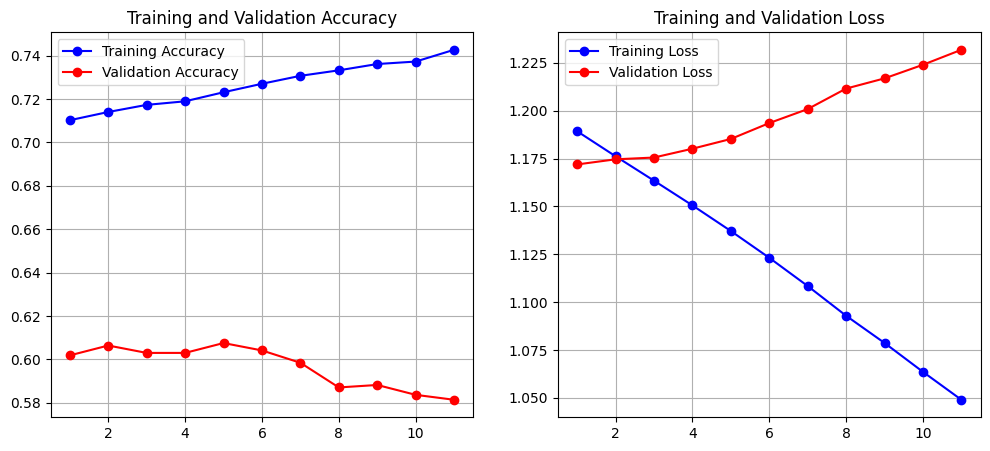


Loading the best tuned model from: /content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_merging', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



--- Final Evaluation on Validation Set (using best tuned model) ---

Generating predictions for evaluation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step

--- Classification Report (Validation Set) ---
               precision    recall  f1-score   support

        No DR       0.88      0.86      0.87       465
         Mild       0.18      0.52      0.27        63
     Moderate       0.63      0.35      0.45       240
       Severe       0.13      0.19      0.15        42
Proliferative       0.09      0.06      0.07        69

     accuracy                           0.60       879
    macro avg       0.38      0.40      0.36       879
 weighted avg       0.66      0.60      0.61       879


--- Confusion Matrix (Validation Set) ---


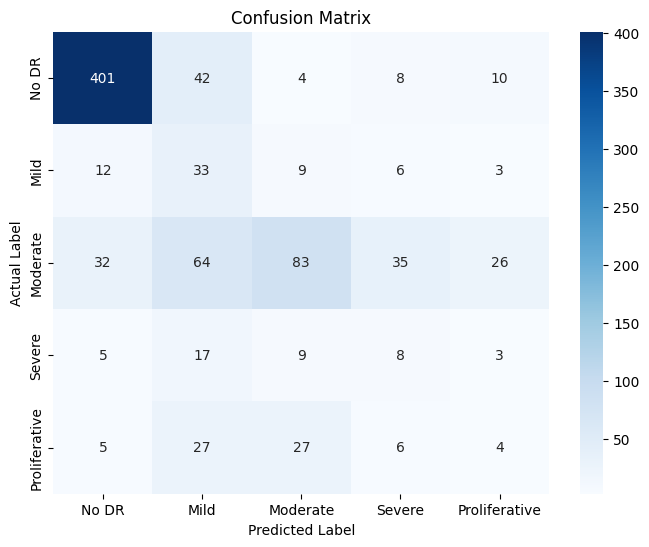

In [19]:
# --- Re-training with Class Weights and a Lower Learning Rate ---

# First, re-define the learning rate
learning_rate_tuned = 1e-4

# Re-compile the model to reset its state and apply the new learning rate
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate_tuned, # Using the new, lower learning rate
        weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

# Define a new path for the improved model
best_model_tuned_path = "/content/drive/MyDrive/Colab_Datasets/Swin_model_best_weights_tuned.keras"

# We can reuse the early stopping callback, but we need a new ModelCheckpoint
model_checkpoint_tuned_callback = ModelCheckpoint(
    filepath=best_model_tuned_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

print("\nStarting the third training experiment with class weights and tuned learning rate...")
history_tuned = model.fit(
    dataset,
    epochs=150,
    validation_data=dataset_val,
    callbacks=[early_stopping_callback, model_checkpoint_tuned_callback],
    class_weight=class_weights_dict # Applying the calculated class weights
)

print("\n--- Tuned Training Finished ---")

# --- Analysis of the Tuned Model ---

# 1. Plot the new training history
print("\nPlotting training history from the tuned experiment...")
plot_training_history(history_tuned)

# 2. Load and evaluate the final, tuned model
print(f"\nLoading the best tuned model from: {best_model_tuned_path}")
best_tuned_model = keras.models.load_model(best_model_tuned_path, custom_objects=custom_objects)

print("\n--- Final Evaluation on Validation Set (using best tuned model) ---")
evaluate_model(best_tuned_model, dataset_val_eval)